In [1]:
import pandas as pd
import numpy as np

# load data
df = pd.read_csv("application_train.csv")


In [2]:
df.head(4)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
y= df['TARGET']
X= df.drop(columns=['TARGET','SK_ID_CURR']) 

In [6]:
X = X.fillna(X.median(numeric_only=True))
X = pd.get_dummies(X, drop_first=True)

In [8]:
#Train-Test Split & Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
#Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_prob_lr = lr.predict_proba(X_test)[:, 1]

In [12]:
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/0e/91/e60d80ce72e5fce94fa672908b1f7ffb881701027130b7d637bb6b6561a4/catboost-1.2.8-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/91/4c/e0ce1ef95d4000ebc1c11801f9b944fa5910ecc15b5e351865763d8657f8/graphviz-0.21-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/102.5 MB 326.8 kB/s eta 0:05:14
   ---------------------------------------- 0.1/102.5 MB 581.0 kB/s eta 0:02:57
   ---------------------------------------- 0.1/102.5 MB 554.9 kB/s eta 0:03:05
   ---------------------------------------- 0.2/102.5 MB 808.4 kB/s eta 0:02:07
   ---------------------------------------- 0.3/102.5 MB 811.7 kB/s eta 0:02:06
   ---------------------------------------- 0.4/

In [13]:
#Model 2: CatBoost (Stronger Model)
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    verbose=0
)

cat.fit(X_train, y_train)
y_prob_cat = cat.predict_proba(X_test)[:, 1]

In [15]:
#Define Business Cost Function
def business_cost(y_true, y_pred, fp_cost=1, fn_cost=5):
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    return fp * fp_cost + fn * fn_cost


FP cost = 1
FN cost = 5 (loan default is expensive)

In [16]:
#Threshold Optimization
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for t in thresholds:
    y_pred = (y_prob_cat >= t).astype(int)
    cost = business_cost(y_test.values, y_pred)
    costs.append(cost)

best_threshold = thresholds[np.argmin(costs)]
best_cost = min(costs)

best_threshold, best_cost

(0.14999999999999997, 20611)

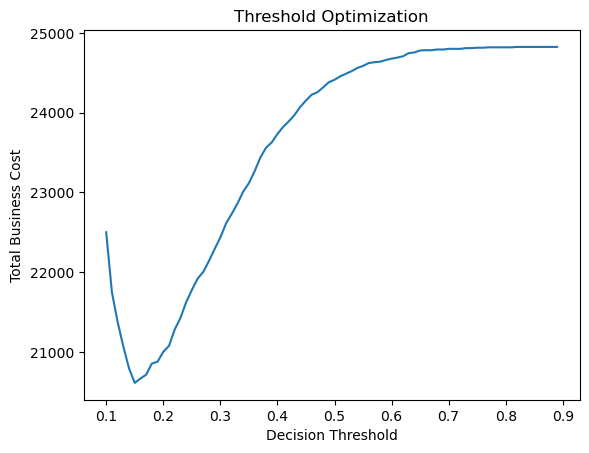

In [17]:
#Visualize Cost vs Threshold
import matplotlib.pyplot as plt

plt.plot(thresholds, costs)
plt.xlabel("Decision Threshold")
plt.ylabel("Total Business Cost")
plt.title("Threshold Optimization")
plt.show()


In [18]:
#Final Evaluation Using Optimized Threshold
from sklearn.metrics import classification_report

final_pred = (y_prob_cat >= best_threshold).astype(int)
print(classification_report(y_test, final_pred))


              precision    recall  f1-score   support

           0       0.95      0.89      0.92     56538
           1       0.25      0.42      0.31      4965

    accuracy                           0.85     61503
   macro avg       0.60      0.65      0.62     61503
weighted avg       0.89      0.85      0.87     61503

